In [2]:
import sys
import numpy as np
from sklearn.model_selection import train_test_split

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src import utils
from src import layers
from src import metrics
from src import callbacks
from src import optimizers
from src import activations
from src import loss_functions
from src import FeedForward

### Constants and Hyperparameters

In [3]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 2e-04 # Learning rate for the optimizer
batch_size = 32 # Number of samples to use for each batch
epochs = 300 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
def generate_sine_dataset(n_samples: int, noise: float = 0.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Method to generate a dataset of samples and targets of a sine function
    
    Parameters: 
    - n_samples (int): Number of samples to generate
    - noise float: Standard deviation of the Gaussian noise. Default is 0 (no noise)
    
    Returns:
    - tuple[np.ndarray, np.ndarray]: Features and target of the dataset
    """

    # Generate random samples
    X = np.random.uniform(-2*np.pi, 2*np.pi, (n_samples, 1)).astype(np.float32)

    # Compute the target
    y = np.sin(X) + np.random.normal(0, noise, (n_samples, 1)).astype(np.float32)
    
    # Return the dataset
    return X, y

In [6]:

# Generate the synthetic dataset of a sine function with some gaussian noise
X, y = generate_sine_dataset(n_samples, noise=data_noise)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_pct, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, random_state=seed)

# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (640, 1) (640, 1)
Validation set: (160, 1) (160, 1)
Testing set: (200, 1) (200, 1)


### Data visualization

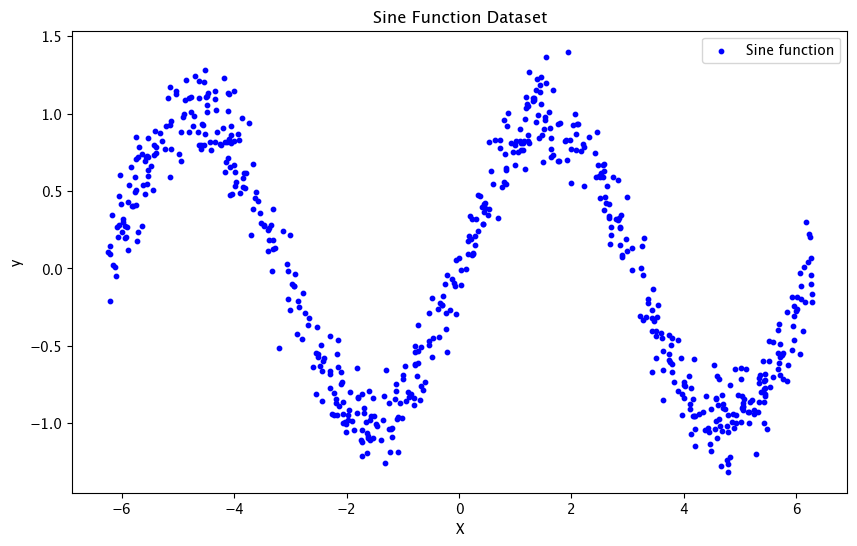

In [7]:
utils.plot_data(
    datasets = [
        {'points': np.array(list(zip(X_train, y_train))), 'label': "Sine function", 'color': "blue", 'size': 10, 'plot_type': 'scatter'},
    ],
    title = "Sine Function Dataset",
    xlabel = "X",
    ylabel = "y"
)

### Building the model

In [8]:
# Create the model
model = FeedForward([
    layers.Dense(num_units=256, activation=activations.Tanh()),
    layers.Dense(num_units=128, activation=activations.Tanh()),
    layers.Dense(num_units=32, activation=activations.Tanh()),
    layers.Dense(num_units=1)
])

# Initialize the optimizer
optimizer = optimizers.Adam(
    learning_rate = learning_rate,
    weight_decay = 0.01
)

# Initialize the error function
error_fn = loss_functions.MeanSquareError()

In [9]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size
model(X_train[:batch_size]);

In [10]:
# Display the model summary
model.summary()


Neural Network (ID: 0)

--------------------------------------------------------------------------------
Layer (type)                            Output Shape        Trainable params #  
dense_1 (Dense)                         (32, 256)           512                 
--------------------------------------------------------------------------------
dense_2 (Dense)                         (32, 128)           32896               
--------------------------------------------------------------------------------
dense_3 (Dense)                         (32, 32)            4128                
--------------------------------------------------------------------------------
dense_4 (Dense)                         (32, 1)             33                  
Total trainable parameters: 37569
--------------------------------------------------------------------------------


### Training the model

In [11]:
# Fit the model
history = model.fit(
    X_train = X_train, 
    y_train = y_train,
    optimizer = optimizer,
    loss_fn = error_fn,
    X_valid = X_valid,
    y_valid = y_valid,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor="val_loss", patience=10)]
)

Epoch 1/300 --> loss: 0.4434 - mean absolute error: 0.5370 | Validation loss: 0.3665 - Validation mean absolute error: 0.5331
Epoch 2/300 --> loss: 0.3176 - mean absolute error: 0.4366 | Validation loss: 0.2486 - Validation mean absolute error: 0.4353
Epoch 3/300 --> loss: 0.2107 - mean absolute error: 0.3405 | Validation loss: 0.1654 - Validation mean absolute error: 0.3447
Epoch 4/300 --> loss: 0.1462 - mean absolute error: 0.2864 | Validation loss: 0.1267 - Validation mean absolute error: 0.2831
Epoch 5/300 --> loss: 0.1253 - mean absolute error: 0.2740 | Validation loss: 0.1214 - Validation mean absolute error: 0.2704
Epoch 6/300 --> loss: 0.1195 - mean absolute error: 0.2719 | Validation loss: 0.1209 - Validation mean absolute error: 0.2697
Epoch 7/300 --> loss: 0.1203 - mean absolute error: 0.2732 | Validation loss: 0.1183 - Validation mean absolute error: 0.2701
Epoch 8/300 --> loss: 0.1205 - mean absolute error: 0.2726 | Validation loss: 0.1173 - Validation mean absolute error:

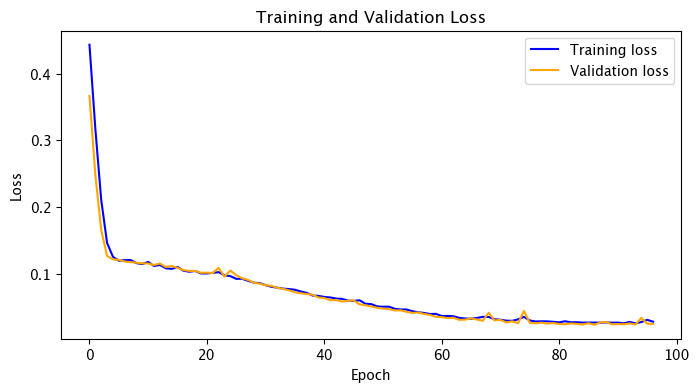

In [12]:
# Plot the training and validation loss
utils.plot_history(history["loss"], history["val_loss"], "Training and Validation Loss", "Epoch", "Loss")

### Evaluation

In [13]:
# Predict the labels
predictions = model(X_test)

In [14]:
# Calculate the mean absolute error
mae = metrics.mean_absolute_error(y_test, predictions)

# Print the mean absolute error
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.11523958881554285


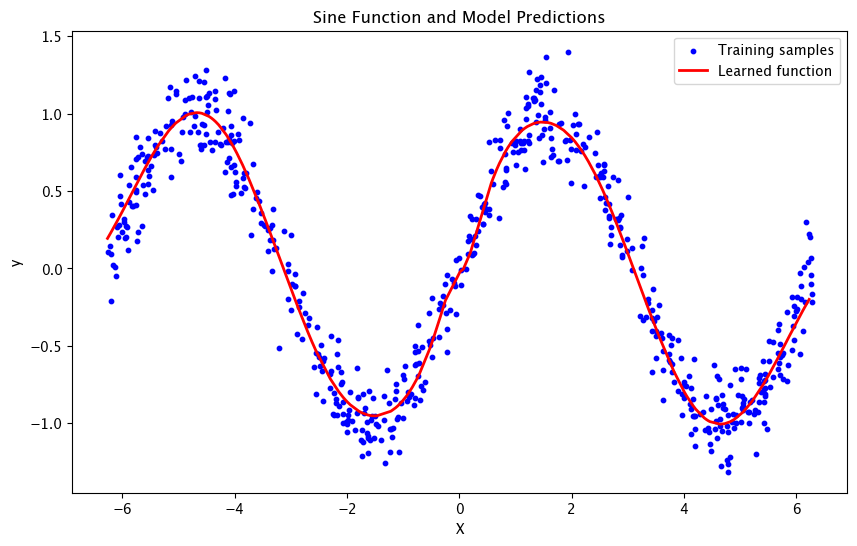

In [15]:
# Plot the sine function and the model predictions
utils.plot_data(
    datasets = [
        {'points': np.array(list(zip(X_train, y_train))), 'label': "Training samples", 'color': "blue", 'size': 10, 'plot_type': 'scatter'},
        {'points': np.array(list(zip(X_test, predictions))), 'label': "Learned function", 'color': "red", 'plot_type': 'line'}
    ],
    title = "Sine Function and Model Predictions",
    xlabel = "X",
    ylabel = "y"
)